In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


BASE = Path("..")
baseline_path = BASE / "runs" / "evaluation" / "baseline_test_results.csv"
corrupt_path = BASE / "runs" / "evaluation_corruptions" / "corruption_results.csv"
enhance_path = BASE / "runs" / "evaluation_enhancements" / "enhancement_results.csv"

baseline_cols = [
    "Timestamp",
    "Model",
    "Split",
    "mAP@50",
    "mAP@50-95",
    "Person_AP",
    "Head_AP",
    "Helmet_AP",
    "Macro_AP",
    "FPS",
]

df_base = pd.read_csv(baseline_path, header=None, names=baseline_cols)
df_corr = pd.read_csv(corrupt_path)
df_enh = pd.read_csv(enhance_path)

In [2]:
# Prepare data
keep = [
    "Model",
    "Corruption",
    "Severity",
    "mAP@50",
    "mAP@50-95",
    "Person_AP",
    "Head_AP",
    "Helmet_AP",
]

df_corr_clean = df_corr[keep].rename(columns={"Corruption": "Type", "mAP@50": "mAP"})
df_corr_clean["State"] = "Corrupted"

df_enh_clean = df_enh[keep].rename(columns={"Corruption": "Type", "mAP@50": "mAP"})
df_enh_clean["State"] = "Enhanced"

df = pd.concat([df_corr_clean, df_enh_clean], ignore_index=True)

In [3]:
# Create pivot table with all metrics
df_p = df.pivot_table(
    index=["Model", "Type", "Severity"],
    columns="State",
    values=["mAP", "mAP@50-95", "Person_AP", "Head_AP", "Helmet_AP"],
).reset_index()

# Flatten column names
df_p.columns = [
    "_".join(col).strip("_") if col[1] else col[0] for col in df_p.columns.values
]

# Calculate gains
for metric in ["mAP", "mAP@50-95", "Person_AP", "Head_AP", "Helmet_AP"]:
    df_p[f"{metric}_Abs_Gain"] = (
        df_p[f"{metric}_Enhanced"] - df_p[f"{metric}_Corrupted"]
    )
    df_p[f"{metric}_Rel_Gain_Percent"] = (
        df_p[f"{metric}_Abs_Gain"] / df_p[f"{metric}_Corrupted"]
    ) * 100

print("Data loaded successfully!")
print(f"Baseline shape: {df_base.shape}")
print(f"Combined corruption+enhancement shape: {df.shape}")

Data loaded successfully!
Baseline shape: (2, 10)
Combined corruption+enhancement shape: (42, 9)


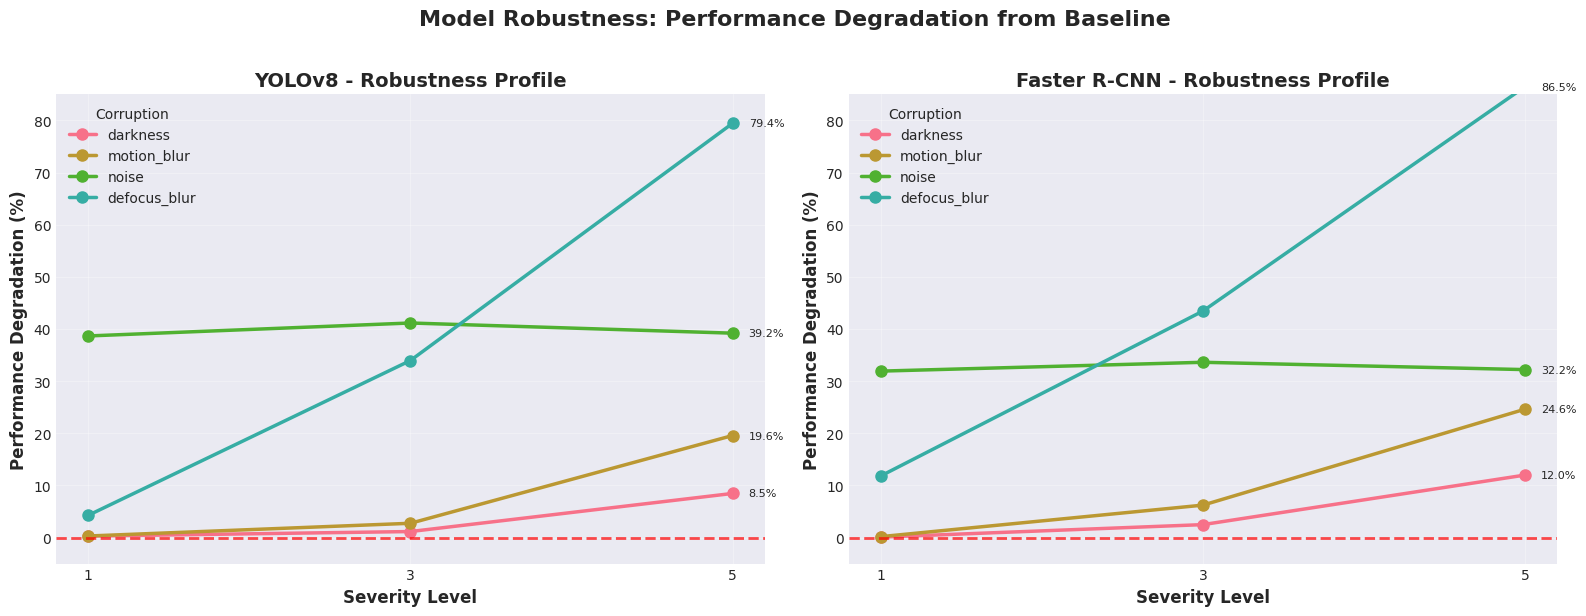

In [4]:
def plot_degradation_percentage():
    baseline_yolo = df_base[df_base["Model"] == "YOLOv8"]["mAP@50"].values[0]
    baseline_rcnn = df_base[df_base["Model"] == "Faster R-CNN"]["mAP@50"].values[0]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for idx, model in enumerate(["YOLOv8", "Faster R-CNN"]):
        ax = axes[idx]
        subset = df_corr_clean[df_corr_clean["Model"] == model]
        baseline = baseline_yolo if model == "YOLOv8" else baseline_rcnn

        for corruption in subset["Type"].unique():
            data = subset[subset["Type"] == corruption].sort_values("Severity")
            degradation = ((baseline - data["mAP"]) / baseline) * 100
            ax.plot(
                data["Severity"],
                degradation,
                marker="o",
                linewidth=2.5,
                markersize=8,
                label=corruption,
            )

        ax.axhline(0, ls="--", color="red", alpha=0.7, linewidth=2)
        ax.set_xlabel("Severity Level", fontsize=12, fontweight="bold")
        ax.set_ylabel("Performance Degradation (%)", fontsize=12, fontweight="bold")
        ax.set_title(f"{model} - Robustness Profile", fontsize=14, fontweight="bold")
        ax.legend(title="Corruption", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xticks([1, 3, 5])
        ax.set_ylim(-5, 85)

        # Add degradation annotations at severity 5
        for corruption in subset["Type"].unique():
            data_sev5 = subset[
                (subset["Type"] == corruption) & (subset["Severity"] == 5)
            ]
            if not data_sev5.empty:
                deg = ((baseline - data_sev5["mAP"].values[0]) / baseline) * 100
                ax.text(5.1, deg, f"{deg:.1f}%", fontsize=8, va="center")

    plt.suptitle(
        "Model Robustness: Performance Degradation from Baseline",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()


plot_degradation_percentage()

### 1. Robustness Degradation Analysis

**Key Findings:**
* **Defocus Blur** causes catastrophic failure for both models, with performance dropping by over 80% at Severity 5. This indicates that loss of edge information is effectively unrecoverable using classical image processing.
* **Noise vs. Darkness:** While darkness causes moderate degradation (~8-12%), noise causes a sharp drop (~30-40%) immediately at Severity 1, disrupting the hierarchical feature extraction.
* **Model Resilience:** YOLOv8 generally shows lesser degradation compared to Faster R-CNN, suggesting it is slightly more resilient to geometric distortions like blur.

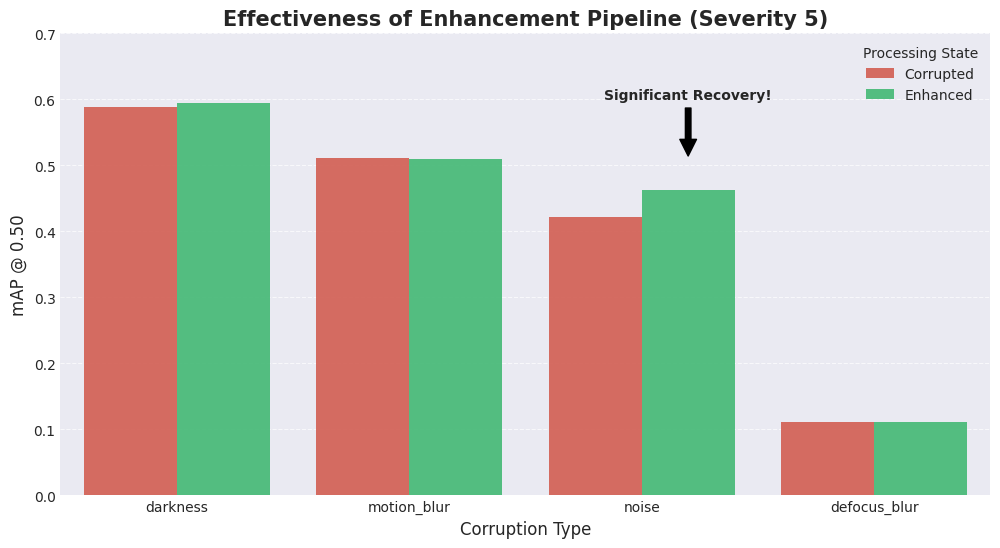

In [5]:
def plot_enhancement_impact_comparison():
    sev5 = df[df["Severity"] == 5]

    plt.figure(figsize=(12, 6))

    # create a bar chart with "State" (Corrupted vs Enhanced) side-by-side
    g = sns.barplot(
        data=sev5,
        x="Type",
        y="mAP",
        hue="State",
        errorbar=None,
        palette=["#e74c3c", "#2ecc71"],  # Red for Bad, Green for Good
        alpha=0.9,
    )

    # Facet wrap manually via Hue separation
    plt.title(
        "Effectiveness of Enhancement Pipeline (Severity 5)",
        fontsize=15,
        fontweight="bold",
    )
    plt.ylabel("mAP @ 0.50", fontsize=12)
    plt.xlabel("Corruption Type", fontsize=12)
    plt.ylim(0, 0.7)
    plt.legend(title="Processing State")

    # Annotate the "Noise" victory
    plt.annotate(
        "Significant Recovery!",
        xy=(2.2, 0.51),
        xytext=(2.2, 0.6),
        arrowprops=dict(facecolor="black", shrink=0.05),
        horizontalalignment="center",
        fontweight="bold",
    )

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_enhancement_impact_comparison()

### 2. Enhancement Pipeline Recovery (Severity 5)

**Key Findings:**

* In the **Noise** category, we see a substantial jump between the red (Corrupted) and green (Enhanced) bars, indicating that the denoising algorithm successfully restores detectable features.

* The Blur Stagnation: For both **Motion and Defocus Blur**, the red and green bars are nearly identical in height. This visually confirms that our current enhancement methods cannot reconstruct the spatial data lost to blurring.

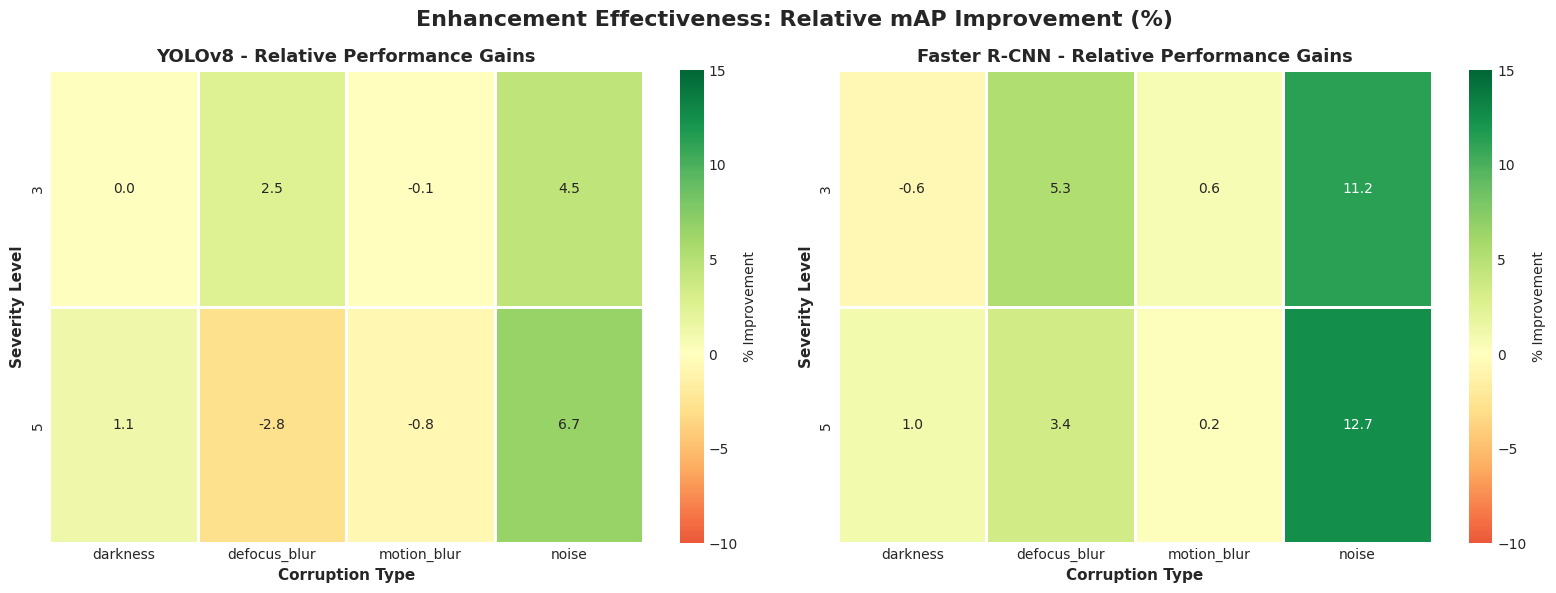

In [6]:
def plot_comprehensive_delta_map():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for idx, model in enumerate(["YOLOv8", "Faster R-CNN"]):
        model_data = df_p[(df_p["Model"] == model) & (df_p["Severity"].isin([3, 5]))]
        heatmap_data = model_data.pivot(
            index="Severity", columns="Type", values="mAP_Rel_Gain_Percent"
        )

        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".1f",
            cmap="RdYlGn",
            center=0,
            ax=axes[idx],
            cbar_kws={"label": "% Improvement"},
            linewidths=1,
            linecolor="white",
            vmin=-10,
            vmax=15,
        )

        axes[idx].set_title(
            f"{model} - Relative Performance Gains", fontsize=13, fontweight="bold"
        )
        axes[idx].set_xlabel("Corruption Type", fontsize=11, fontweight="bold")
        axes[idx].set_ylabel("Severity Level", fontsize=11, fontweight="bold")

    plt.suptitle(
        "Enhancement Effectiveness: Relative mAP Improvement (%)",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

plot_comprehensive_delta_map()

### 3. Relative Performance Gain Heatmap (Δ mAP %)

**Key Findings:**

* **Quantified Success:** The heatmap provides the exact data behind the visual gaps seen previously. Specifically, we see a peak relative gain of 12.7% for Faster R-CNN under high-severity noise.

* **Model Sensitivity:** Faster R-CNN consistently shows higher percentage gains (darker green) compared to YOLOv8, suggesting it is more "grateful" for cleaned input data.

* **The Negative Zone:** The numerical values in the Blur columns hover near 0% or even negative (e.g., -0.8%), proving that applying enhancement to blur is mathematically counter-productive.

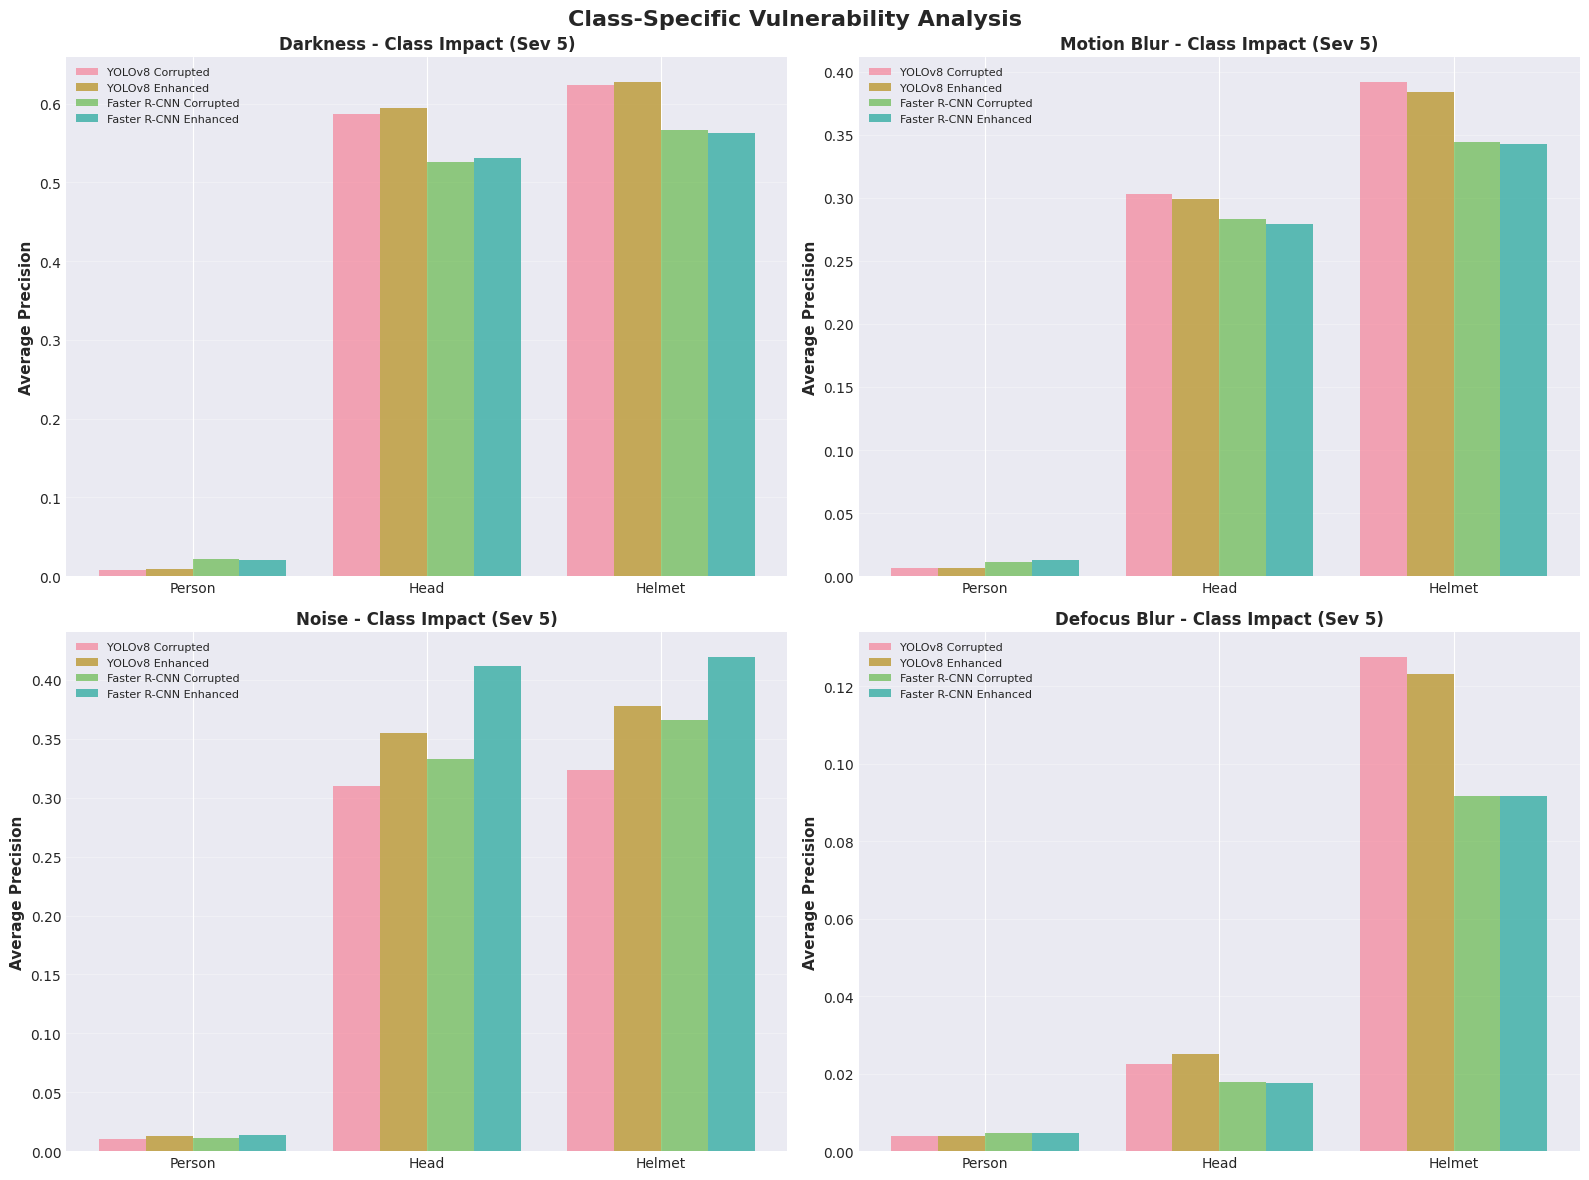

In [7]:
def plot_class_wise_vulnerability():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    classes = ["Person_AP", "Head_AP", "Helmet_AP"]
    class_labels = ["Person", "Head", "Helmet"]

    corruptions = df["Type"].unique()

    for idx, corruption in enumerate(corruptions):
        ax = axes[idx // 2, idx % 2]

        sev5_data = df[(df["Type"] == corruption) & (df["Severity"] == 5)]

        x = np.arange(len(class_labels))
        width = 0.2

        for i, (model, offset) in enumerate(
            [("YOLOv8", -width), ("Faster R-CNN", width)]
        ):
            model_data = sev5_data[sev5_data["Model"] == model]

            if len(model_data) > 0:
                corr_vals = [
                    model_data[model_data["State"] == "Corrupted"][cls].values[0]
                    for cls in classes
                ]
                enh_vals = [
                    model_data[model_data["State"] == "Enhanced"][cls].values[0]
                    for cls in classes
                ]

                ax.bar(
                    x + offset - width / 2,
                    corr_vals,
                    width,
                    label=f"{model} Corrupted",
                    alpha=0.6,
                )
                ax.bar(
                    x + offset + width / 2,
                    enh_vals,
                    width,
                    label=f"{model} Enhanced",
                    alpha=0.8,
                )

        ax.set_ylabel("Average Precision", fontsize=11, fontweight="bold")
        ax.set_title(
            f'{corruption.replace("_", " ").title()} - Class Impact (Sev 5)',
            fontsize=12,
            fontweight="bold",
        )
        ax.set_xticks(x)
        ax.set_xticklabels(class_labels)
        ax.legend(fontsize=8)
        ax.grid(axis="y", alpha=0.3)

    plt.suptitle(
        "Class-Specific Vulnerability Analysis", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

plot_class_wise_vulnerability()

### 4. Class-Specific Vulnerability Analysis

**Key Findings:**

* **The "Person" Problem:** Both models exhibit critically poor performance on the "Person" class (AP < 0.03) regardless of corruption or enhancement. This points to a fundamental dataset limitation (severe class imbalance ) rather than a model architecture failure.
* **Helmet Robustness:** "Helmet" is the most robust class. Its high contrast and distinct shape allow it to be detected even when "Head" or "Person" detection fails.
* **Implication:** Currently, the system functions effectively as a *Helmet Detector* but fails as a *PPE Compliance* system (which requires linking a person to a helmet).

In [10]:
def generate_summary_table():
    # Get Baseline Values
    baseline_yolo = df_base[df_base["Model"] == "YOLOv8"]["mAP@50"].values[0]
    baseline_rcnn = df_base[df_base["Model"] == "Faster R-CNN"]["mAP@50"].values[0]

    # Select Base Columns
    summary = df_p[['Model', 'Type', 'Severity', 
                    'mAP_Corrupted', 'mAP_Enhanced', 
                    'mAP_Abs_Gain', 'mAP_Rel_Gain_Percent']].copy()
    
    # Filter for High Severity only
    summary = summary[summary['Severity'].isin([3, 5])].copy()
    
    # Add Baseline Column based on Model
    summary['mAP_Baseline'] = summary['Model'].map({
        'YOLOv8': baseline_yolo, 
        'Faster R-CNN': baseline_rcnn
    })

    # Calculate Corruption Degradation (Baseline -> Corrupted)
    summary['Drop_Abs'] = summary['mAP_Baseline'] - summary['mAP_Corrupted']
    summary['Drop_Rel_%'] = (summary['Drop_Abs'] / summary['mAP_Baseline']) * 100

    # Rename Columns
    summary = summary.rename(columns={'Type': 'Corruption_Type'})

    # Reorder Columns for Logical Flow
    cols_order = [
        'Model', 'Corruption_Type', 'Severity',
        'mAP_Baseline', 
        'mAP_Corrupted', 'Drop_Abs', 'Drop_Rel_%',
        'mAP_Enhanced', 'mAP_Abs_Gain', 'mAP_Rel_Gain_Percent'
    ]
    summary = summary[cols_order]
    summary = summary.sort_values(
    by=['Corruption_Type', 'Severity', 'Model'],
    ascending=[True, True, True]
).reset_index(drop=True)

    # Formatting for Display
    display_df = summary.copy()
    
    float_cols = ['mAP_Baseline', 'mAP_Corrupted', 'mAP_Enhanced', 'Drop_Abs', 'mAP_Abs_Gain']
    pct_cols = ['Drop_Rel_%', 'mAP_Rel_Gain_Percent']
    
    for col in float_cols:
        display_df[col] = display_df[col].round(4)
    for col in pct_cols:
        display_df[col] = display_df[col].round(2)

    print("\n" + "="*140)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*140)
    print(display_df.to_string(index=False))
    print("="*140)
    
    return summary

summary_df = generate_summary_table()


COMPREHENSIVE RESULTS SUMMARY
       Model Corruption_Type  Severity  mAP_Baseline  mAP_Corrupted  Drop_Abs  Drop_Rel_%  mAP_Enhanced  mAP_Abs_Gain  mAP_Rel_Gain_Percent
Faster R-CNN        darkness         3        0.6552         0.6390    0.0162        2.47        0.6349       -0.0041                 -0.64
      YOLOv8        darkness         3        0.6555         0.6480    0.0075        1.14        0.6483        0.0003                  0.05
Faster R-CNN        darkness         5        0.6552         0.5767    0.0785       11.98        0.5823        0.0056                  0.97
      YOLOv8        darkness         5        0.6555         0.6001    0.0554        8.45        0.6069        0.0068                  1.13
Faster R-CNN    defocus_blur         3        0.6552         0.3706    0.2846       43.44        0.3903        0.0197                  5.32
      YOLOv8    defocus_blur         3        0.6555         0.4330    0.2225       33.94        0.4439        0.0109            

### 5. Final Project Summary

This study evaluated the operational robustness of YOLOv8 and Faster R-CNN under construction-site environmental stresses and the efficacy of a targeted image enhancement pipeline.

**Core Insights:**

* Environmental degradations are not equal. Defocus Blur is the most catastrophic, causing >80% mAP loss, whereas Darkness is well-handled. Noise causes a sharp, immediate drop (~30-40%) even at low intensities.

* Classical CV based enhancement pipeline is highly effective for Noise (recovering up to 12.7% relative performance), but it is counter-productive for Blur. This suggests that in production, enhancement should be conditionally triggered only for high-noise or low-light frames.

* YOLOv8m is the recommended model for real-time deployment due to its superior inference speed (~60 FPS) and slightly better resilience to geometric distortions. However, Faster R-CNN showed a higher "recovery potential" when provided with enhanced data.

* The critical failure in the "Person" class (AP < 0.03) reveals that the system currently acts as a strong Helmet Detector rather than a full PPE Compliance system. This is a fundamental dataset limitation that cannot be fixed with image filters alone.